## Findability computation from retrieval simulation outputs, and further analysis

In this notebook, we do the following:
- From the data of large-scale retrieval simulation step, we calculate _findability_ scores for each document of the corpus
- Plot Lorenz Curve for f(d) distribution and calculate Gini-coefficient G and Mean f(d)

In [2]:
import pickle
import json

### Findability Computation using ranks from retrieval simulation

In [2]:
with open('./WT10g/ranks/fd_ranks_dfr-pl2.json', 'r') as f:
    ranks = json.load(f)

In [3]:
fd = {}
for docid in ranks:
    len_qd = len(ranks[docid])
    if len_qd == 0:
        continue
    xi_d_qs = [0 if r == -1 else 1/r for r in ranks[docid]]
    # sanity check
    if len_qd != len(xi_d_qs):
        print('len unequal found. This sanity check failed!')
        break
    # f(d) computation
    fd[int(docid)] = round(sum(xi_d_qs)/len_qd, 4)

with open('./WT10g/fd_dfr-pl2.pickle', 'wb') as f:
    pickle.dump(fd, f)

### Lorenz Curve, Gini-coefficient, f(d) distribution, Mean f(d)

Robust04

LMDIR: Mean Findability, <f> = 0.6327
BM25: Mean Findability, <f> = 0.6640
DFR-PL2: Mean Findability, <f> = 0.6672

LMDIR: Gini Coefficient, G = 0.1387
BM25: Gini Coefficient, G = 0.1456
DFR-PL2: Gini Coefficient, G = 0.1424

r(d) BM25, c = 100: Gini Coefficient, G = 0.3307



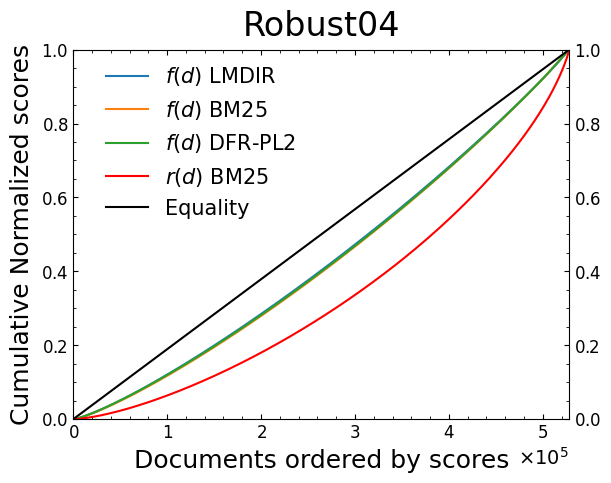

In [20]:
import re
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import os

# Corpus
corpus = 'Robust04'
print(corpus)
print()

# Specify the directory path
directory_path = f'./{corpus}/'

fd_paths_list = []

# Get the current working directory
current_directory = os.getcwd()

# Get the absolute path of the directory
absolute_directory_path = os.path.join(current_directory, directory_path)

# Get all files and directories inside the specified directory
items = os.listdir(absolute_directory_path)

# Iterate over the items
for item in items:
    # Check if it is a file and starts with 'fd'
    if os.path.isfile(os.path.join(absolute_directory_path, item)) and item.startswith('fd'):
        # Get the relative path of the file
        relative_path = os.path.relpath(os.path.join(absolute_directory_path, item), current_directory)
        fd_paths_list.append(relative_path)

for fd_path in fd_paths_list:
    model = re.split(r'_|\.', fd_path.split('/')[1])[1]
    
    with open(fd_path, 'rb') as f:
        fd = pickle.load(f)
    
    mean = sum(fd.values())/len(fd)
    print(f'{model.upper()}: Mean Findability, <f> = {mean:.4f}')

# List of line symbols
# line_symbols = ['o', 'x', '^']
print()
for fd_path in fd_paths_list:
    model = re.split(r'_|\.', fd_path.split('/')[1])[1]
    
    with open(fd_path, 'rb') as f:
        fd = pickle.load(f)
    
    N = len(fd)         # No. of docs in fd
    X = np.arange(N)    # No. of docs array
    equality = np.cumsum(np.full(N, 1.0/N))

    fd_sorted = sorted(fd.values())    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*fd_sorted[i-1] for i in range(1,N+1)])/(N*sum([fd_sorted[j-1] for j in range(1,N+1)]))
    print(f'{model.upper()}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([f for f in fd_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    # plt.plot(X,Y,'-', label=f'{model.upper()}: G = {G:.2f}')
    plt.plot(X,Y,'-', label=f'$f(d)$ {model.upper()}')

model = 'bm25'
    
with open('../Retrievability-experiments/allrd_robust04.pickle', 'rb') as f:
    all_rd = pickle.load(f)

c = 100
r_d = all_rd[f'rd_{model}_{c}']

N = 528155
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))
# setting non-retrieved documents' retrieval count to zero and including them in r_d
for num in range(N):
    r_d[num] = r_d.get(num, 0)
r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids

# Gini Coefficient G
G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
print(f'\nr(d) {model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

# Lorenz Curve of r(d) scores
Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
Y = Y/np.max(Y)
plt.plot(X,Y,'-', label=f'$r(d)$ {model.upper()}', color='red')

    
plt.plot(X,equality,'-', label='Equality', color='black')
# plt.legend(loc='upper left', frameon=False, fontsize=12)
plt.legend(loc=(0.05,0.52), frameon=False, fontsize=15)
plt.title(f'{corpus}', fontsize=24, pad=10)
plt.xlabel('Documents ordered by scores', fontsize=18, labelpad=5)
plt.ylabel('Cumulative Normalized scores', fontsize=18, labelpad=5)
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True, labelright=True)
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(14)

print()
plt.savefig(f'lorenz_curve_{corpus}.svg', format='svg', bbox_inches='tight')
plt.show()

MSMARCO

LMDIR: Mean Findability, <f> = 0.5209
BM25: Mean Findability, <f> = 0.5985
DFR-PL2: Mean Findability, <f> = 0.6133

LMDIR: Gini Coefficient, G = 0.3774
BM25: Gini Coefficient, G = 0.3116
DFR-PL2: Gini Coefficient, G = 0.3007

r(d) BM25, c = 100: Gini Coefficient, G = 0.5227



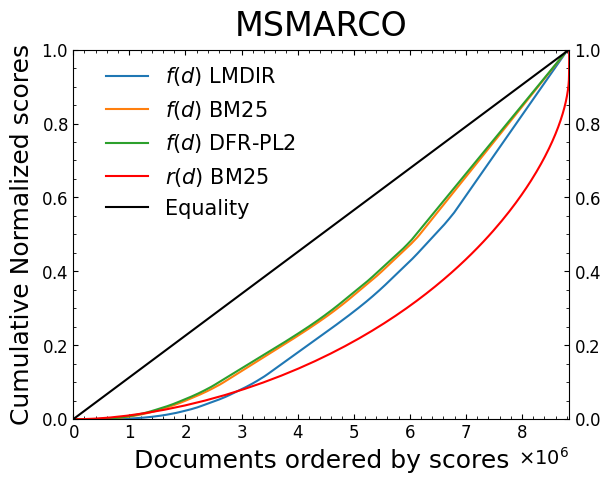

In [25]:
import re
import numpy as np
import matplotlib.pyplot as plt
import os

# Corpus
corpus = 'MSMARCO'
print(corpus)
print()

# Specify the directory path
directory_path = f'./{corpus}/'

fd_paths_list = []

# Get the current working directory
current_directory = os.getcwd()

# Get the absolute path of the directory
absolute_directory_path = os.path.join(current_directory, directory_path)

# Get all files and directories inside the specified directory
items = os.listdir(absolute_directory_path)

# Iterate over the items
for item in items:
    # Check if it is a file and starts with 'fd'
    if os.path.isfile(os.path.join(absolute_directory_path, item)) and item.startswith('fd'):
        # Get the relative path of the file
        relative_path = os.path.relpath(os.path.join(absolute_directory_path, item), current_directory)
        fd_paths_list.append(relative_path)

for fd_path in fd_paths_list:
    model = re.split(r'_|\.', fd_path.split('/')[1])[1]
    
    with open(fd_path, 'rb') as f:
        fd = pickle.load(f)
    
    mean = sum(fd.values())/len(fd)
    print(f'{model.upper()}: Mean Findability, <f> = {mean:.4f}')

print()

for fd_path in fd_paths_list:
    model = re.split(r'_|\.', fd_path.split('/')[1])[1]
    
    with open(fd_path, 'rb') as f:
        fd = pickle.load(f)
    
    N = len(fd)         # No. of docs in fd
    X = np.arange(N)    # No. of docs array
    equality = np.cumsum(np.full(N, 1.0/N))

    fd_sorted = sorted(fd.values())    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*fd_sorted[i-1] for i in range(1,N+1)])/(N*sum([fd_sorted[j-1] for j in range(1,N+1)]))
    print(f'{model.upper()}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([f for f in fd_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    # plt.plot(X,Y,'-', label=f'{model.upper()}: G = {G:.2f}')
    plt.plot(X,Y,'-', label=f'$f(d)$ {model.upper()}')

model = 'bm25'
    
with open('../Retrievability-experiments/allrd_MSMARCO.pickle', 'rb') as f:
    all_rd = pickle.load(f)

c = 100
r_d = all_rd[f'rd_{model}_{c}']

N = 8841823
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))
# setting non-retrieved documents' retrieval count to zero and including them in r_d
for num in range(N):
    r_d[num] = r_d.get(num, 0)
r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids

# Gini Coefficient G
G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
print(f'\nr(d) {model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

# Lorenz Curve of r(d) scores
Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
Y = Y/np.max(Y)
plt.plot(X,Y,'-', label=f'$r(d)$ {model.upper()}', color='red')

plt.plot(X,equality,'-', label='Equality', color='black')
# plt.legend(loc='upper left', frameon=False, fontsize=12)
plt.legend(loc=(0.05,0.52), frameon=False, fontsize=15)
plt.title(f'{corpus}', fontsize=24, pad=10)
plt.xlabel('Documents ordered by scores', fontsize=18, labelpad=5)
plt.ylabel('Cumulative Normalized scores', fontsize=18, labelpad=5)
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True, labelright=True)
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(14)

print()
plt.savefig(f'lorenz_curve_{corpus}.svg', format='svg', bbox_inches='tight')
plt.show()

WT10g

LMDIR: Mean Findability, <f> = 0.5173
BM25: Mean Findability, <f> = 0.5895
DFR-PL2: Mean Findability, <f> = 0.5888

LMDIR: Gini Coefficient, G = 0.2847
BM25: Gini Coefficient, G = 0.2503
DFR-PL2: Gini Coefficient, G = 0.2497

r(d) BM25, c = 100: Gini Coefficient, G = 0.4925



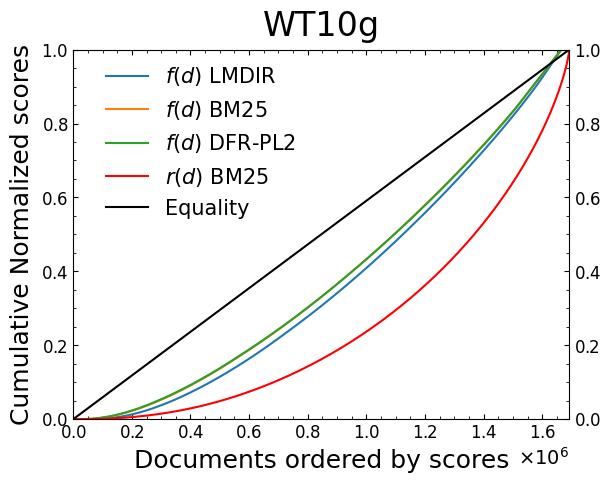

In [27]:
import re
import numpy as np
import matplotlib.pyplot as plt
import os

# Corpus
corpus = 'WT10g'
print(corpus)
print()

# Specify the directory path
directory_path = f'./{corpus}/'

fd_paths_list = []

# Get the current working directory
current_directory = os.getcwd()

# Get the absolute path of the directory
absolute_directory_path = os.path.join(current_directory, directory_path)

# Get all files and directories inside the specified directory
items = os.listdir(absolute_directory_path)

# Iterate over the items
for item in items:
    # Check if it is a file and starts with 'fd'
    if os.path.isfile(os.path.join(absolute_directory_path, item)) and item.startswith('fd'):
        # Get the relative path of the file
        relative_path = os.path.relpath(os.path.join(absolute_directory_path, item), current_directory)
        fd_paths_list.append(relative_path)

for fd_path in fd_paths_list:
    model = re.split(r'_|\.', fd_path.split('/')[1])[1]
    
    with open(fd_path, 'rb') as f:
        fd = pickle.load(f)
    
    mean = sum(fd.values())/len(fd)
    print(f'{model.upper()}: Mean Findability, <f> = {mean:.4f}')

print()

for fd_path in fd_paths_list:
    model = re.split(r'_|\.', fd_path.split('/')[1])[1]
    
    with open(fd_path, 'rb') as f:
        fd = pickle.load(f)
    
    N = len(fd)         # No. of docs in fd
    X = np.arange(N)    # No. of docs array
    equality = np.cumsum(np.full(N, 1.0/N))

    fd_sorted = sorted(fd.values())    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*fd_sorted[i-1] for i in range(1,N+1)])/(N*sum([fd_sorted[j-1] for j in range(1,N+1)]))
    print(f'{model.upper()}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([f for f in fd_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    # plt.plot(X,Y,'-', label=f'{model.upper()}: G = {G:.2f}')
    plt.plot(X,Y,'-', label=f'$f(d)$ {model.upper()}')
    
model = 'bm25'
    
with open('../Retrievability-experiments/allrd_WT10g.pickle', 'rb') as f:
    all_rd = pickle.load(f)

c = 100
r_d = all_rd[f'rd_{model}_{c}']

N = 1692096
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))
# setting non-retrieved documents' retrieval count to zero and including them in r_d
for num in range(N):
    r_d[num] = r_d.get(num, 0)
r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids

# Gini Coefficient G
G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
print(f'\nr(d) {model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

# Lorenz Curve of r(d) scores
Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
Y = Y/np.max(Y)
plt.plot(X,Y,'-', label=f'$r(d)$ {model.upper()}', color='red')

plt.plot(X,equality,'-', label='Equality', color='black')
# plt.legend(loc='upper left', frameon=False, fontsize=12)
plt.legend(loc=(0.05,0.52), frameon=False, fontsize=15)
plt.title(f'{corpus}', fontsize=24, pad=10)
plt.xlabel('Documents ordered by scores', fontsize=18, labelpad=5)
plt.ylabel('Cumulative Normalized scores', fontsize=18, labelpad=5)
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
ax = plt.gca()
ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True, labelright=True)
ax.tick_params(axis='both', labelsize=12)
ax.xaxis.get_offset_text().set_fontsize(14)

print()
plt.savefig(f'lorenz_curve_{corpus}.svg', format='svg', bbox_inches='tight')
plt.show()